In [1]:
import numpy as np
from scipy import stats

import pymc3 as pm

import torch
import pyro
import pyro.infer as infer
import pyro.distributions as dist
from torch.distributions import constraints

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
colors = sns.color_palette().as_hex()
n_colors = len(colors)

seed = 100
np.random.seed(seed)

# 同時確率

- 複数の未知変数の推論をしたい
  - 二項分布において、成功率$\theta$と試行数$n$が共に未知で、成功回数だけがわかっているとする
  

## 問題設定

- 二項分布に従うデータ$k$がある
  - $k$は複数の標本がある
- 成功率$\theta$と試行数$n$が共に未知
  - $\theta$と$n$に事前分布を設定する

## データ

In [3]:
# 5個の標本
ks = [16, 18, 22, 25, 27]

## 推論（PyMC3）

### モデルの定義

In [4]:
n_max = 500

with pm.Model() as model:
    n_ = pm.Categorical('n_', np.ones(n_max)/n_max)
    n = pm.Deterministic('n', n_+max(ks))
    
    theta = pm.Beta('theta', 1, 1)

    for i, k in enumerate(ks):
        y = pm.Binomial(f'y_{i}', p=theta, n=n, observed=k)

### 推論

In [5]:
with model:
    trace = pm.sample(5000, chains=3)

Multiprocess sampling (3 chains in 2 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [n_]
>NUTS: [theta]


Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.6239665906382089, but should be close to 0.8. Try to increase the number of tuning steps.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3584032087393447, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


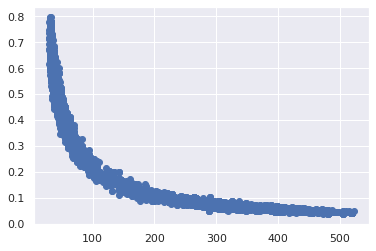

In [6]:
plt.scatter(trace['n'], trace['theta'])

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'n'}>,
        <AxesSubplot:title={'center':'n'}>]], dtype=object)

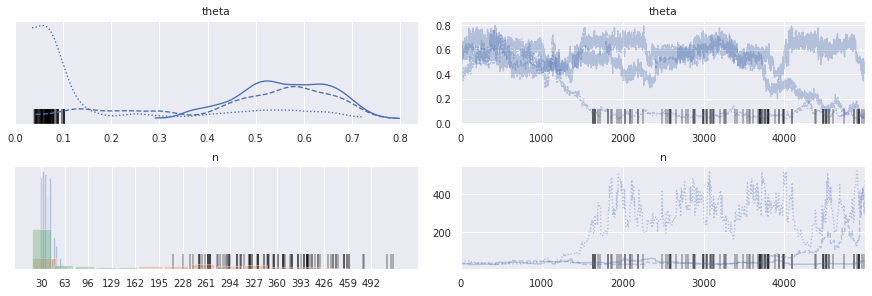

In [7]:
pm.traceplot(trace, var_names=['theta', 'n'])

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'theta'}>,
       <AxesSubplot:title={'center':'n'}>], dtype=object)

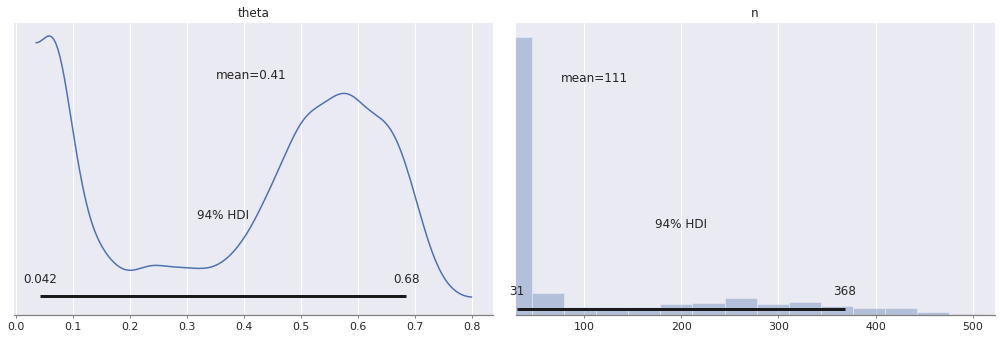

In [8]:
pm.plot_posterior(trace, var_names=['theta', 'n'])